In [1]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
from pygimli.viewer.mpl import showDataContainerAsMatrix
from glob import glob

In [2]:
DATA = [ert.load(filename) for filename in glob("*.dat")]
for data in DATA:
    data["k"] = ert.geometricFactors(data, dim=3)
    data["rhoa"] = data["r"] * data["k"]
    data["r"] = 0
    data.remove([154, 155, 323])
    print(data)

Data: Sensors: 144 data: 1253, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
Data: Sensors: 144 data: 1253, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
Data: Sensors: 144 data: 1253, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
Data: Sensors: 144 data: 1253, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
Data: Sensors: 144 data: 1253, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
Data: Sensors: 144 data: 1253, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']


Mesh: Nodes: 1029 Cells: 960 Boundaries: 1988


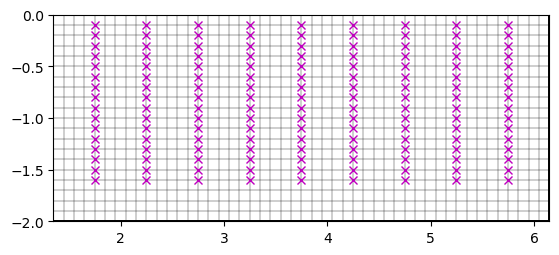

In [3]:
ex = np.unique(pg.x(data))
ez = np.unique(pg.z(data))
dx = 0.1
nb = 4
xmin, xmax = min(ex) - nb*dx, max(ex) + nb*dx
zmin, zmax = min(ez) - nb*dx, 0
x = np.arange(xmin, xmax+.001, dx)
z = np.arange(zmin, zmax+.001, dx)
grid = mt.createGrid(x, z, marker=2)
ax, cb = pg.show(grid)
ax.plot(pg.x(data), pg.z(data), "mx")
print(grid)

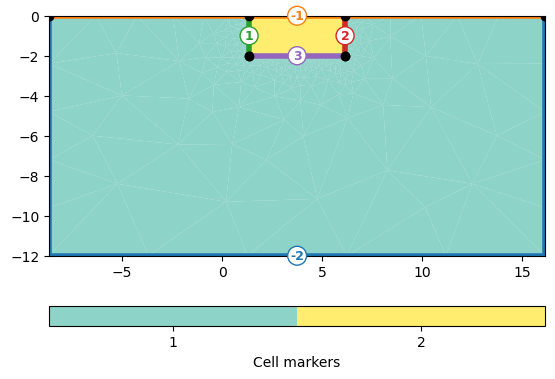

In [4]:
mesh = mt.appendTriangleBoundary(grid, marker=1, boundary=5, worldMarkers=1)
ax, cb = pg.show(mesh, markers=True)

In [5]:
fop = pg.frameworks.MultiFrameModelling(ert.ERTModelling)
fop.setData(DATA)
fop.setMesh(mesh)
print(fop.mesh())  # important to call mesh() function once!
print(fop.parameterCount)

27/06/23 - 22:48:33 - pyGIMLi - INFO - Found 2 regions.
27/06/23 - 22:48:33 - pyGIMLi - INFO - Region with smallest marker (1) set to background
27/06/23 - 22:48:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/06/23 - 22:48:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/06/23 - 22:48:33 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 5278 Cells: 6564 Boundaries: 5958
27/06/23 - 22:48:34 - pyGIMLi - WARNING - Parameter count is 0


960 model cells
Mesh: Nodes: 5278 Cells: 6564 Boundaries: 5958
0
5760


In [6]:
dataVec = np.concatenate([data["rhoa"] for data in DATA])
errorVec = np.concatenate([data["err"] for data in DATA])
startModel = fop.createStartModel(dataVec)
print(startModel)

5760 [64.90427134270173,...,64.90427134270173]


In [7]:
# fop.setStartModel(startModel)  # needed if fop.createStartModel not implem.
inv = pg.Inversion(fop=fop, startModel=startModel, verbose=True)
fop.createConstraints()
# inv.setRegularization(C=fop.C)  # here we could also do other things?
# inv.startModel = 100
model = inv.run(dataVec, errorVec, maxIter=10, startModel=startModel)

27/06/23 - 22:48:34 - pyGIMLi - INFO - Starting inversion.
27/06/23 - 22:48:34 - pyGIMLi - INFO - Creating forward mesh from region infos.


fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x0000028AB0F13180>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000028AB0F19D00>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000028AB0D5D3B0>
min/max (data): 6.95/200
min/max (error): 3%/1.0e+07%
min/max (start model): 64.9/64.9
--------------------------------------------------------------------------------


RuntimeError: RegionManager knows no mesh.

In [ ]:
# %% show results
kw = dict(cMin=10, cMax=300, logScale=True, cMap="Spectral_r")
pd = fop.paraDomain
mod = np.reshape(model, [len(DATA), -1])

In [ ]:
fig, ax = pg.plt.subplots(2, (len(DATA)+1)//2)
for i, mo in enumerate(mod):
    pg.show(pd, mo, ax=ax.flat[i], **kw)

In [ ]:
rkw = dict(cMin=0.5, cMax=2, cMap="bwr", logScale=True)
fig, ax = pg.plt.subplots(2, (len(DATA)+1)//2)
pg.show(pd, mod[0], ax=ax.flat[0], **kw)
for i, mo in enumerate(mod[1:]):
    pg.show(pd, mo/mod[0], ax=ax.flat[i+1], **rkw)